In [1]:
import pandas as pd
import numpy as np

# Drawing Map

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

In [3]:
# reading csv file containing the coordinates of calgary city
df_boundary = pd.read_csv('City_Boundary_layer.csv')

# reading coordinates
df_coordinates = df_boundary['the_geom']
df_cord = df_coordinates[0][10:].replace(")","")
df_cord_split = df_cord.split(",")

# list of longitudes
lons = [float((x.strip().split())[0]) for x in df_cord_split]

# list of latitudes
lats = [float((x.strip().split())[1]) for x in df_cord_split]

# min and max latitude and longitude values
long_max = max(lons)
long_min = min(lons)
lat_max = max(lats)
lat_min = min(lats)

# coordinates for drawing boundary of calgary
ls = ((lat_max,long_max),(lat_max,long_min),(lat_min,long_min),(lat_min,long_max),(lat_max,long_max))

In [4]:
# central location of calgary city
locat = [51.049999, -114.066666]

# displays the map of Calgary city
m = folium.Map(location = locat, zoom_start=10)

# adding boundary coordinates to the map
folium.PolyLine(ls, color="red", weight=2.5, opacity=1).add_to(m)
m

In [5]:
# dividing into grids
vertical_cord_upper = []
vertical_cord_lower = []
horizontal_cord_left = []
horizontal_cord_right = []

# calculating the coordinates for joining the lines
for i in range(1, 10):
    long = long_min + (i*(long_max - long_min)/10)
    lat = lat_min + (i*(lat_max - lat_min)/10)
    vertical_cord_upper.append((lat_max,long))
    vertical_cord_lower.append((lat_min,long))
    horizontal_cord_left.append((lat, long_min))
    horizontal_cord_right.append((lat, long_max))
    horizontal_cord_right


In [6]:
# plotting the grids
for i in range(0,9):
    vertical_cord = []
    horizontal_cord = []
    vertical_cord.append(vertical_cord_upper[i])
    vertical_cord.append(vertical_cord_lower[i])
    horizontal_cord.append(horizontal_cord_left[i])
    horizontal_cord.append(horizontal_cord_right[i])
    folium.PolyLine(vertical_cord, color="brown", weight=1, opacity=1).add_to(m)
    folium.PolyLine(horizontal_cord, color="brown", weight=1, opacity=1).add_to(m)
m

In [7]:
# get coordinates of the grids
# coordinates are stored as a list of tuples in grid_cord
# Each tuple contains 4 values for lat min, lat max, long min, and long max
grid_cord = []
lat_grid_min = lat_min
long_grid_min = long_min
lat_grid_max = 0
long_grid_max = 0

for i in range (1,11):
    lat_grid_max = lat_grid_min + ((lat_max - lat_min)/10)
    long_grid_min = long_min
    for j in range (1,11):
        long_grid_max = long_grid_min + ((long_max - long_min)/10)
        grid_cord.append((lat_grid_min,lat_grid_max,long_grid_min,long_grid_max))
        long_grid_min = long_grid_max
    lat_grid_min = lat_grid_max

In [8]:
# checking the coordinates
feature_group = folium.FeatureGroup("Locations")
for i in range (0,100):
    values = grid_cord[i]
    #print(values)
    lat_test = (values[0] + values[1])/2
    long_test = (values[2] + values[3])/2
    feature_group.add_child(folium.Marker(location=[lat_test,long_test],popup="sayam"))
m.add_child(feature_group)

# Counting number of cameras in each grid

In [9]:
# counting no of cameras in each grid

# reading csv file for cameras
df_camera = pd.read_csv("Traffic_Camera_Locations.csv")

# dictionary for storing the values
dict_data = {}

# column for adding the number of cameras in each grid
dict_data['num_cameras']= []

# algo for counting the number of cameras in each grid 

# coordinates of each grid
for i in grid_cord:
    
    # checking if the coordinates lie in that grid
    bool_Series = df_camera['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_camera['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_camera_filter = df_camera[bool_Series] 

    # appending num of cameras for that grid
    dict_data['num_cameras'].append(df_camera_filter.shape[0])
    
#df = pd.DataFrame(dict_data)
#df

# Calculating Average Speed

In [10]:
# finding average speed limit

# reading speed limits
df_speed_all = pd.read_csv("Speed_Limits.csv")

# PARSING DATE
df_speed_all['CREATED_DT'] = pd.to_datetime(df_speed_all['CREATED_DT'], format = '%Y-%m-%d')

# filtering data for year 2018
df_speed = df_speed_all[df_speed_all['CREATED_DT'].dt.year == 2018]

# remove own index with default index 
df_speed.reset_index(inplace = True, drop = True)

# df_speed_loc has only speeds and location coordinates
df_speed_loc = df_speed[['SPEED','multiline']]

# removing extra characters from location
df_speed_loc['multiline'] = df_speed_loc['multiline'].apply(lambda x: x[16:].replace("(","").replace(")",""))

# checks for NAN values
df_speed_loc.isnull().any()

# creating lists for latitude, longitude, and speed for 'speed data'
speed_lat_ls =[]
speed_long_ls = []
speed_ls = []

# algo for getting lats, longs, and speed
for i in range (df_speed_loc.shape[0]):
    coordinates = df_speed_loc.loc[i,'multiline'].split(",")
    for j in coordinates:
        cord_space = j.split()
        speed_long_ls.append(cord_space[0])
        speed_lat_ls.append(cord_space[1])
        speed_ls.append(df_speed_loc.loc[i,'SPEED'])
    
# print(len(speed_ls))
# print(len(speed_long_ls))
# print(len(speed_lat_ls))



C:\Users\nehas\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Calculating speeds for each grid

In [11]:
# counting average speed in each grid
pd.set_option('display.max_rows', 500)

dict_speed = {'Speed':speed_ls, 'Latitude':speed_lat_ls, 'Longitude':speed_long_ls}

# creating new data frame for speed with lats, longs, and speeds 
df_speed_new = pd.DataFrame.from_dict(dict_speed)
df_speed_new = df_speed_new.astype(float)
avg_speed_ls = []

#i iterates through all the grids
for i in grid_cord:
    
    # checks if coordinate lies in particular grid
    bool_Series = df_speed_new['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_speed_new['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_speed_new_filter = df_speed_new[bool_Series]
    
    # calculating average of the volumes
    avg_speed_ls.append(df_speed_new_filter['Speed'].mean())


# assigning the vlume data to the data frame
# df['avg_speed'] = avg_speed_ls

# # appending Nan values to zero
# df['avg_speed'] = df['avg_speed'].fillna(0)
# df
dict_data['avg_speed'] = avg_speed_ls

# Calculating Average Volumes

Fetching latitudes, longitudes, and volume data

In [12]:
# reading volume file
traffic_vol_csv_all = pd.read_csv("Traffic_Volumes_for_2018.csv")

# filtering data for year 2018
traffic_vol_csv = traffic_vol_csv_all[traffic_vol_csv_all['YEAR'] == 2018]

# remove own index with default index 
traffic_vol_csv.reset_index(inplace = True, drop = True)

# refining data in multilinestring to fetch individual coordinates
traffic_vol_csv['multilinestring'] = traffic_vol_csv['multilinestring'].apply(lambda x: x[16:].replace("(","").replace(")",""))

# creating lists for latitude, longitude, and volume for 'traffic_vol_csv'
vol_lat_list =[]
vol_long_list = []
vol_list = []

# algo for getting lats, longs, and speed
for i in range (traffic_vol_csv.shape[0]):
    coordinates = traffic_vol_csv.loc[i,'multilinestring'].split(",")
    for j in coordinates:
        cord_space = j.split()
        vol_long_list.append(float(cord_space[0]))
        vol_lat_list.append(float(cord_space[1]))
        vol_list.append(float(traffic_vol_csv.loc[i,'VOLUME']))
    
# print(len(vol_list))
# print(len(vol_long_list))
# print(len(vol_lat_list))

C:\Users\nehas\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


# Finding average volumes for each grid

In [13]:
df_volume_new = pd.DataFrame({'Volume':vol_list, 'Latitude':vol_lat_list, 'Longitude':vol_long_list})

# list containing average values of volume for all grids
volume_grid_ls = []

#algo for finding the average
#i iterates through all the grids
for i in grid_cord:
    
    # checks if coordinate lies in particular grid
    bool_Series = df_volume_new['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_volume_new['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    
    # getting data corresponding to the coordinates that lie in that grid
    df_volume_new_filter = df_volume_new[bool_Series]
    
    # calculating average of the volumes
    volume_grid_ls.append(df_volume_new_filter['Volume'].mean()) 


# assigning the vlume data to the data frame
# df['avg_volume'] = volume_grid_ls

# # appending Nan values to zero
# df['avg_volume'] = df['avg_volume'].fillna(0)
# df
dict_data['avg_volume'] = volume_grid_ls
#dict_data

# Traffic Signals

In [14]:
# reading traffic signals file
df_signals_all = pd.read_csv("Traffic_Signals.csv")

# PARSING DATE
df_signals_all['INSTDATE'] = pd.to_datetime(df_signals_all['INSTDATE'], format = '%Y-%m-%d')

# filtering data for year 2018
df_signals = df_signals_all[df_signals_all['INSTDATE'].dt.year == 2018]

# remove own index with default index 
df_signals.reset_index(inplace = True, drop = True)

# list for appending number of signals in each grid
ls = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_signals['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_signals['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of signals for a grid that is being iterated
    df_sig = df_signals[bool_Series]
    # appending the count of signals for a grid that is being iterated
    ls.append(df_sig.shape[0])

# adding list of signal to the data frame
# df['num_signals'] = ls
# df_signals.shape
dict_data['num_signal'] = ls
# dict_data

# Number of Traffic Signs

In [15]:
# reading signs.csv file
df_signs = pd.read_csv("Traffic_Signs.csv")

# accessing the coordinates and signs
df_signs = df_signs[['BLADE_TYPE','POINT']]

# refining the coordinate data
df_signs['POINT'] = df_signs['POINT'].apply(lambda x: x[7:].replace(")",""))

# filtering empty rows
df_signs['BLADE_TYPE'].replace('', np.nan, inplace=True)
df_signs.dropna(subset=['BLADE_TYPE'], inplace=True)

# creating latitude and longitude from point
df_signs['latitude'] = df_signs['POINT'].apply(lambda x: x.split()[1])
df_signs['latitude'] = df_signs['latitude'].astype(float)
df_signs['longitude'] = df_signs['POINT'].apply(lambda x: x.split()[0])
df_signs['longitude'] = df_signs['longitude'].astype(float)
#print(df_signs.shape)

In [16]:
# list for appending number of signs in each grid
ls_signs = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_signs['latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_signs['longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of signs for a grid that is being iterated
    df_sig = df_signs[bool_Series]
    # appending the count of signs for a grid that is being iterated
    ls_signs.append(df_sig.shape[0])

print(sum(ls_signs))
# adding list of signs to the data frame
# df['num_signs'] = ls_signs
# df.head()
dict_data['num_signs'] = ls_signs
#dict_data

207238


# Daily Weather Conditions

In [17]:
def download_weather_data(station, year, month=1, daily=True):
    """ returns a DataFrame with weather data from climate.weather.gc.ca"""
   # url string with variables station, year and month
    url_template = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station}&Year={year}&Month={month}&Day=14&timeframe={time_frame}&submit=Download+Data"

    # replace variables in string with actual values
    if daily:
        url = url_template.format(station = station, year = year, month = month, time_frame = 2)
    else:
        url = url_template.format(station= station, year = year, month = month, time_frame = 1)

    # read data into dataframe, use headers and set Date/Time column as index
    weather_data = pd.read_csv(url, index_col='Date/Time', parse_dates=True)

    # replace the degree symbol in the column names
    weather_data.columns = [col.replace('\xb0', '') for col in weather_data.columns]
    
    return (weather_data)

# getting data 2018
df_weather_temp = download_weather_data(station=50430, year=2018, month=5)
df_weather_vis = download_weather_data(station=50430, year=2018, month=5, daily = False)
display(df_weather_temp.shape, df_weather_temp.shape, df_weather_vis.columns, df_weather_vis.shape)

(365, 30)

(365, 30)

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
       'Month', 'Day', 'Time', 'Temp (C)', 'Temp Flag', 'Dew Point Temp (C)',
       'Dew Point Temp Flag', 'Rel Hum (%)', 'Rel Hum Flag',
       'Wind Dir (10s deg)', 'Wind Dir Flag', 'Wind Spd (km/h)',
       'Wind Spd Flag', 'Visibility (km)', 'Visibility Flag',
       'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx', 'Hmdx Flag', 'Wind Chill',
       'Wind Chill Flag', 'Weather'],
      dtype='object')

(744, 27)

#Finding Average Visibility

# Calculating number of incidents

In [18]:
df_incident_all = pd.read_csv("Traffic_Incidents.csv", parse_dates = ['START_DT'])

# PARSING DATE

#df_incident_all['START_DT'] = pd.to_datetime(df_INCIDENT_all['START_DT'], format = '%d-%m-%y % ')

# filtering data for year 2018
df_incident = df_incident_all[df_incident_all['START_DT'].dt.year == 2018]
print(df_incident.shape)

# remove own index with default index 
df_incident.reset_index(inplace = True, drop = True)

# list for appending number of accidents in each grid
ls_incident = []

# iterating through grids
for i in grid_cord:
    # checking the latitue and longitudes
    bool_Series = df_incident['Latitude'].between(float(i[0]), float(i[1]), inclusive = True) & df_incident['Longitude'].between(float(i[2]), float(i[3]), inclusive = True)
    # getting the list of accidents for a grid that is being iterated
    df_acc = df_incident[bool_Series]
    # appending the count of accidents for a grid that is being iterated
    ls_incident.append(df_acc.shape[0])

# adding list of accidents to the data frame
# df['num_accidents'] = ls_incident
# df
dict_data['num_accidents'] = ls_incident
dict_data

(6567, 10)


{'num_cameras': [0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  1,
  2,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  3,
  3,
  2,
  1,
  0,
  0,
  0,
  0,
  0,
  3,
  9,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  2,
  8,
  22,
  5,
  5,
  0,
  0,
  0,
  0,
  1,
  2,
  3,
  4,
  6,
  6,
  2,
  0,
  0,
  0,
  1,
  2,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  2,
  0,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'avg_speed': [nan,
  nan,
  nan,
  nan,
  nan,
  55.063291139240505,
  70.55762081784387,
  80.44554455445545,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  59.48905109489051,
  73.30347144456887,
  69.0077519379845,
  75.27245949926362,
  76.34146341463415,
  nan,
  nan,
  nan,
  40.714285714285715,
  55.751633986928105,
  54.5617816091954,
  63.678260869565214,
  70.95919828203293,
  66.10738255033557,
  60.0,
  nan,
  nan,
  nan,
  nan,
  30.0,
  57.66393442622951,
  73

In [19]:
df = pd.DataFrame(dict_data)
df = df.replace(np.nan, 0)


In [36]:
# reassembling accidents data count for each day

df_accidents_cleaned = df_incident[['START_DT','Count']]
df_accidents_cleaned['Date'] = pd.to_datetime(df_accidents_cleaned['START_DT'])
df_accidents_sample = df_accidents_cleaned.resample('D', on='Date').sum()
df_accidents_sample.reset_index(inplace=True)
df_accidents_sample = df_accidents_sample[df_accidents_sample['Date'].between('2018-01-01', '2018-12-31', inclusive = True)]
df_accidents_sample.head()


C:\Users\nehas\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Date,Count
0,2018-01-01,12
1,2018-01-02,30
2,2018-01-03,26
3,2018-01-04,22
4,2018-01-05,20


# drawing heat map of accident data

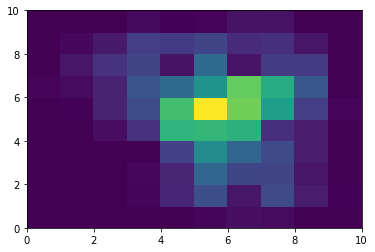

In [21]:
index = ['0', '1', '2', '3', '4','5','6','7','8','9']
columns = ['0', '1', '2', '3', '4','5','6','7','8','9']
#x = np.reshape(list_data, (100, 28)).T
list_accidents = list(df['num_accidents'])
np_list = np.reshape(list_accidents, (10, 10))
df_plot_accident = pd.DataFrame(np_list, index=index, columns=columns)

plt.pcolor(df_plot_accident)
plt.show()

# drawing heat map of avg_volume

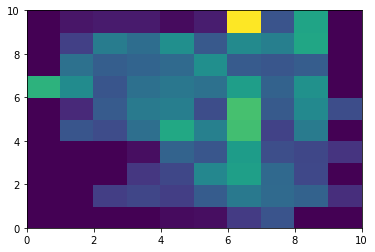

In [23]:
index = ['0', '1', '2', '3', '4','5','6','7','8','9']
columns = ['0', '1', '2', '3', '4','5','6','7','8','9']
#x = np.reshape(list_data, (100, 28)).T
list_volume_heat = list(df['avg_volume'])
np_list_volume = np.reshape(list_volume_heat, (10, 10))
df_plot_volume = pd.DataFrame(np_list_volume, index=index, columns=columns)

plt.pcolor(df_plot_volume)
plt.show()

# Analysis of accident with cameras

Text(0, 0.5, 'Number of accidents')

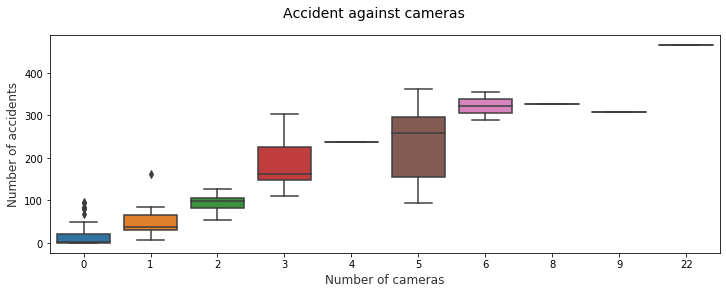

In [24]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Accident against cameras', fontsize=14)

sns.boxplot(x="num_cameras", y="num_accidents", data=df,  ax=ax)
ax.set_xlabel("Number of cameras",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

# Analysis of accident with volume

Text(0, 0.5, 'Number of accidents')

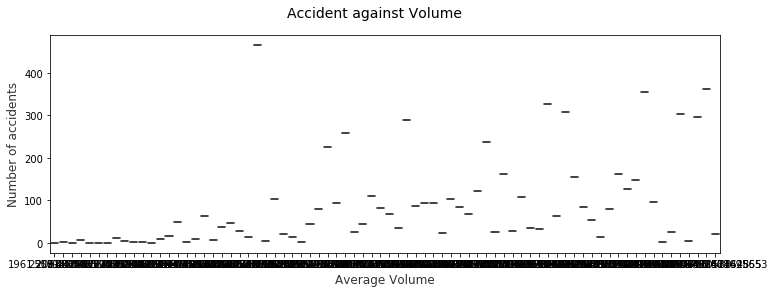

In [25]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Accident against Volume', fontsize=14)

sns.boxplot(x="avg_volume", y="num_accidents", data=df,  ax=ax)
ax.set_xlabel("Average Volume",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

No handles with labels found to put in legend.


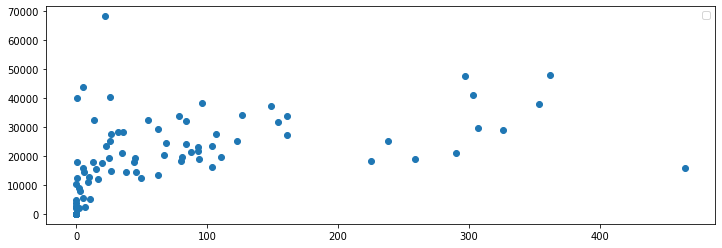

In [26]:
#fig = plt.figure()
fig,ax = plt.subplots(figsize=(12,4))
#ax = fig.add_subplot(111)

ax.scatter(y=df['avg_volume'], x=df['num_accidents'])

plt.legend(loc='upper right')

plt.show()

# Analysis of accident with signs

Text(0, 0.5, 'Number of accidents')

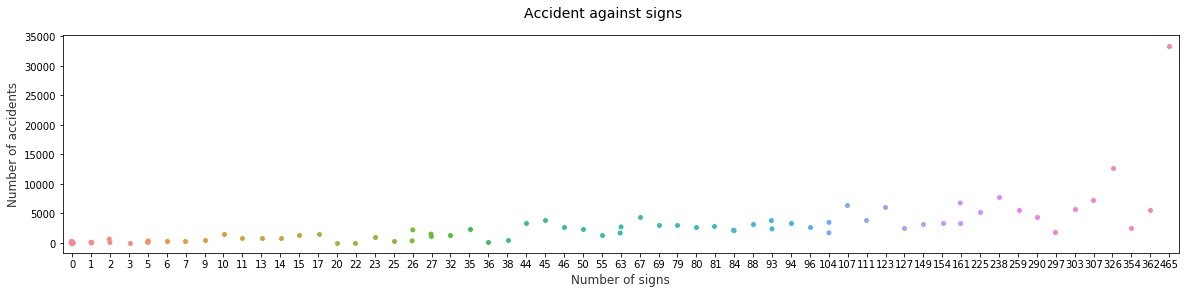

In [27]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(20, 4))
f.suptitle('Accident against signs', fontsize=14)
sns.stripplot(y="num_signs", x="num_accidents", data=df,  jitter=0.05)
ax.set_xlabel("Number of signs",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

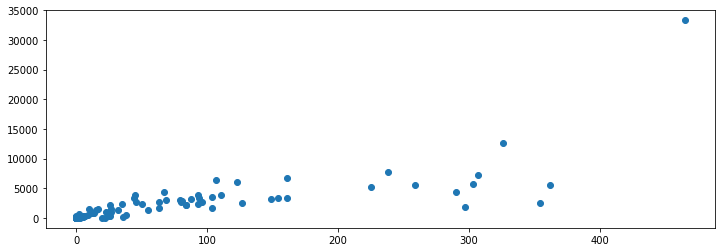

In [28]:
#fig = plt.figure()
fig,ax = plt.subplots(figsize=(12,4))
#ax = fig.add_subplot(111)

ax.scatter(y=df['num_signs'], x=df['num_accidents'])

#plt.legend(loc='upper right')

plt.show()

# Analysis of accident with signals

Text(0, 0.5, 'Number of accidents')

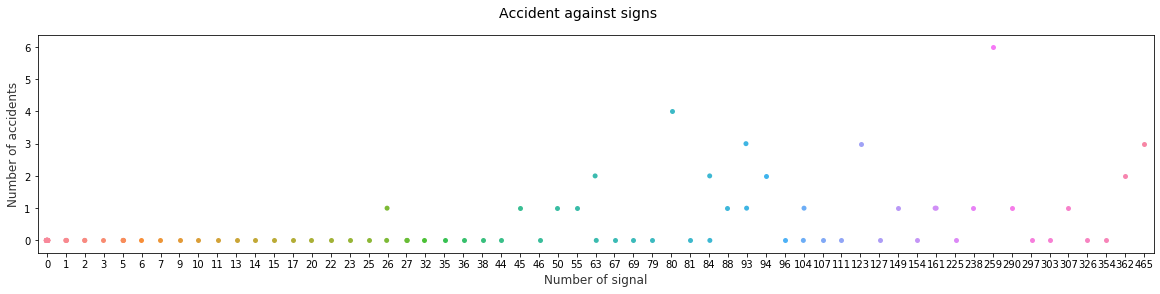

In [29]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(20, 4))
f.suptitle('Accident against signs', fontsize=14)
sns.stripplot(y="num_signal", x="num_accidents", data=df,  jitter=0.05)
ax.set_xlabel("Number of signal",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

Text(0, 0.5, 'Number of accidents')

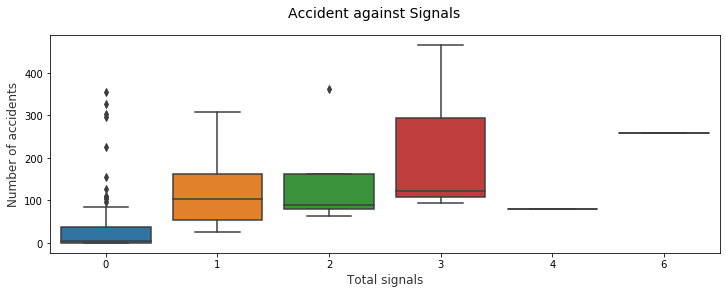

In [30]:
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('Accident against Signals', fontsize=14)

sns.boxplot(x="num_signal",y="num_accidents", data=df,  ax=ax)
ax.set_xlabel("Total signals",size = 12,alpha=0.8)
ax.set_ylabel("Number of accidents",size = 12,alpha=0.8)

# Analysis of weather and traffic incidents data¶

In [31]:
# fetching dataframe for Weather

df_weather = download_weather_data(station=50430, year=2018, month=1, daily = False)
for i in range(2,13):
    df_weather1 = download_weather_data(station=50430, year=2018, month=i, daily = False)
    df_weather = pd.concat([df_weather,df_weather1])

In [32]:
# accessing visibility, temp, and date/time

df_weather_cleaned = df_weather[['Temp (C)','Visibility (km)']]
df_weather_cleaned.reset_index(inplace = True)
df_weather_cleaned.head()

,Date/Time,Temp (C),Visibility (km)
0,2018-01-01 00:00:00,-28.1,24.1
1,2018-01-01 01:00:00,-28.6,24.1
2,2018-01-01 02:00:00,-29.1,24.1
3,2018-01-01 03:00:00,-30.0,24.1
4,2018-01-01 04:00:00,-27.6,24.1


In [37]:
# Computing daily visibilty and temperature

df_weather_cleaned_sample = df_weather_cleaned.resample('D', on='Date/Time').mean()
df_weather_cleaned_sample.reset_index(inplace=True)
df_weather_cleaned_sample.head()

df_weather_cleaned_sample = df_weather_cleaned_sample.reset_index()
df_merged_acc_weather = pd.merge(df_accidents_sample, df_weather_cleaned_sample, left_on = 'Date', right_on = 'Date/Time')
#df_merged_acc_weather.drop(columns=['Date/Time','index'])
df_merged_acc_weather_final = df_merged_acc_weather[['Date','Count','Temp (C)','Visibility (km)']]


In [38]:
df_merged_acc_weather_final.head()

,Date,Count,Temp (C),Visibility (km)
0,2018-01-01,12,-16.683333,42.570833
1,2018-01-02,30,-3.787500,40.891667
2,2018-01-03,26,-2.391667,39.212500
3,2018-01-04,22,-5.016667,40.891667
4,2018-01-05,20,-0.345833,40.891667


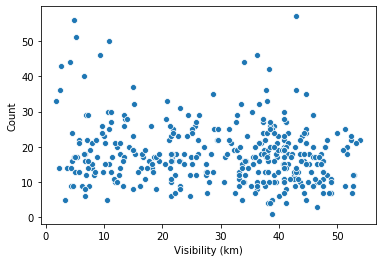

In [39]:
# scatterplot for visibility

sns.scatterplot(x=df_merged_acc_weather_final['Visibility (km)'], y=df_merged_acc_weather_final['Count'], data=df_merged_acc_weather_final)

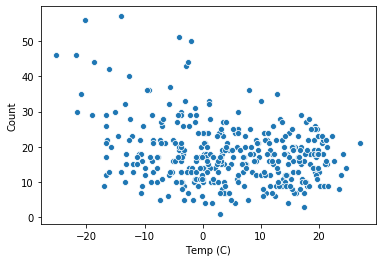

In [40]:
# scatterplot for temp


sns.scatterplot(x=df_merged_acc_weather_final['Temp (C)'], y=df_merged_acc_weather_final['Count'], data=df_merged_acc_weather_final)

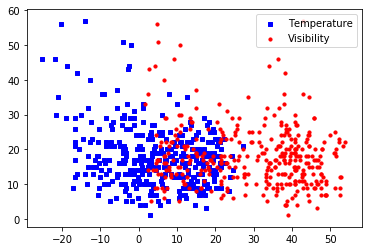

In [41]:
# combined scatter plot

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=df_merged_acc_weather_final['Temp (C)'], y=df_merged_acc_weather_final['Count'], s=10, c='b', marker="s", label='Temperature')
ax1.scatter(x=df_merged_acc_weather_final['Visibility (km)'], y=df_merged_acc_weather_final['Count'], s=10, c='r', marker="o", label='Visibility')
plt.legend(loc='upper right');
plt.show()

# Analysis for Number of Accidents and Speed limit

In [42]:
# dataframe of speed and date
df_speed_cleaned = df_speed[['CREATED_DT','SPEED']]

# resampling df_speed_cleaned dataframe for average speed for each date in year 2018
df_speed_cleaned_avg = df_speed_cleaned.groupby(['CREATED_DT']).mean()

In [43]:
# merging speed and traffic incidents data
df_merged_acc_speed = pd.merge(df_speed_cleaned_avg, df_accidents_sample, left_on = 'CREATED_DT', right_on = 'Date', how='inner')
df_merged_acc_speed_rounded = df_merged_acc_speed.round({"SPEED":1})
df_merged_acc_speed_rounded

,SPEED,Date,Count
0,67.8,2018-10-17,35
1,63.1,2018-10-23,25
2,63.6,2018-10-25,18
3,67.1,2018-10-28,4
4,53.9,2018-10-29,25
5,55.7,2018-10-30,24
6,57.2,2018-10-31,19
7,66.8,2018-11-02,16
8,78.5,2018-11-07,22
9,77.0,2018-12-06,26


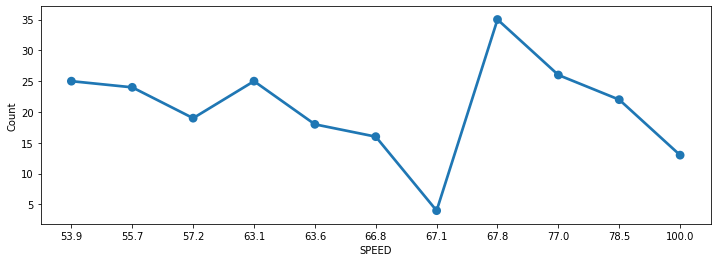

In [44]:
fig,ax = plt.subplots(figsize=(12,4))

sns.pointplot(x='SPEED', y='Count',   data=df_merged_acc_speed_rounded, )

# ax.set_xticks(range(0,10))
# ax.set_xticklabels(range(0,100))
plt.show()


# Finding spearman correlation

In [ ]:
# method for calculating spearman coefficient
def compute_spearman_ranks(x_ranks,y_ranks):
    
    n = len(x_ranks)

    d_square = []
    # d^2 for each row of data ranks input 
    for x,y in zip(x_ranks,y_ranks):
        diff = x-y
        d_square.append(pow(diff,2))

    # sum of d^2     
    sum_d_squares = sum(d_square)

    # calculate spearman formula
    rho = 1 - (6*sum_d_squares/(n*(n**2-1)))

    return rho

# method for calculating ranks of the lists
def compute_rank_of_list(input_list):
    #create a list of value-index pairs
    input_list_index_pair = list(zip(input_list,range(len(input_list))))

    # sort the list 
    input_list_index_pair_sorted = sorted(input_list_index_pair)

    # create the list of ranks
    ranks = [0]*len(input_list)# initialize list with zero

    for i, item in enumerate(input_list_index_pair_sorted):
        ranks[item[1]] = i+1

    return ranks

# spearman coefficient for cameras and accidents

In [ ]:
# for accident and cameras spearman coeffcient

# getting columns of accidents and cameras
df_acc_cameras = df[['num_cameras', 'num_accidents']]
#df_acc_camers = df_acc_cameras.replace(0, np.nan)
df_acc_cameras.dropna(inplace = True)

# getting list of ranks for num_cameras
df_cameras_ls = list(df_acc_cameras['num_cameras'])
df_cameras_rank = compute_rank_of_list(df_cameras_ls)


# getting list of ranks for num_accidents
df_accidents_ls = list(df_acc_cameras['num_accidents'])
df_accidents_rank = compute_rank_of_list(df_accidents_ls)

cameras_coefficient = compute_spearman_ranks(df_cameras_rank, df_accidents_rank)
cameras_coefficient

# calculating the spearman coefficient between the speed and the accidents

In [ ]:
# for accident and speed spearman coeffcient
# getting columns of accidents and cameras
df_acc_speed = df[['avg_speed', 'num_accidents']]
df_acc_speed = df_acc_speed.replace(0, np.nan)
df_acc_speed.dropna(inplace = True)

# getting list of ranks for num_speed
df_speed_ls = list(df_acc_speed['avg_speed'])
df_speed_rank = compute_rank_of_list(df_speed_ls)


# getting list of ranks for num_accidents
df_accidents_ls_speed = list(df_acc_speed['num_accidents'])
df_accidents_rank_speed = compute_rank_of_list(df_accidents_ls_speed)

speed_coefficient = compute_spearman_ranks(df_speed_rank, df_accidents_rank_speed)



# calculating the spearman coefficient between the signs and the accidents

In [ ]:
# for accident and speed spearman coeffcient
# getting columns of accidents and cameras
df_acc_sign = df[['num_signs', 'num_accidents']]
df_acc_sign = df_acc_sign.replace(0, np.nan)
df_acc_sign.dropna(inplace = True)

# getting list of ranks for num_speed
df_sign_ls = list(df_acc_sign['num_signs'])
df_sign_rank = compute_rank_of_list(df_sign_ls)


# getting list of ranks for num_accidents
df_accidents_ls_sign = list(df_acc_sign['num_accidents'])
df_accidents_rank_sign = compute_rank_of_list(df_accidents_ls_sign)

sign_coefficient = compute_spearman_ranks(df_sign_rank, df_accidents_rank_sign)



# calculating the spearman coefficient between the signals and the accidents

In [ ]:
# for accident and speed spearman coeffcient
# getting columns of accidents and cameras
df_acc_signal = df[['num_signal', 'num_accidents']]
#df_acc_signal = df_acc_signal.replace(0, np.nan)
df_acc_signal.dropna(inplace = True)

# getting list of ranks for num_speed
df_signal_ls = list(df_acc_signal['num_signal'])
df_signal_rank = compute_rank_of_list(df_signal_ls)


# getting list of ranks for num_accidents
df_accidents_ls_signal = list(df_acc_signal['num_accidents'])
df_accidents_rank_signal = compute_rank_of_list(df_accidents_ls_signal)

signal_coefficient = compute_spearman_ranks(df_signal_rank, df_accidents_rank_signal)



# calculating the spearman coefficient between the signals and the accidents

In [ ]:
# for accident and volume spearman coeffcient
# getting columns of accidents and volumes
df_acc_vol = df[['avg_volume', 'num_accidents']]
#df_acc_signal = df_acc_signal.replace(0, np.nan)
df_acc_vol.dropna(inplace = True)

# getting list of ranks for num_speed
df_vol_ls = list(df_acc_vol['avg_volume'])
df_volume_rank = compute_rank_of_list(df_vol_ls)


# getting list of ranks for num_accidents
df_accidents_ls_vol = list(df_acc_vol['num_accidents'])
df_accidents_rank_vol = compute_rank_of_list(df_accidents_ls_vol)

volume_coefficient = compute_spearman_ranks(df_volume_rank, df_accidents_rank_vol)



In [ ]:
# printing the spear man coefficient
print("The spearman coefficient between the volume and the accidents are coefficient : " + str(volume_coefficient))
print("The spearman coefficient between the signal and the accidents are coefficient : " + str(signal_coefficient))
print("The spearman coefficient between the sign and the accidents are coefficient : " + str(sign_coefficient))
print("The spearman coefficient between the speed and the accidents are coefficient : " + str(speed_coefficient))
print("The spearman coefficient between the cameras and the accidents are coefficient : " + str(cameras_coefficient))

In [ ]:
# calculating spear man coefficient 
df.corr(method ='spearman')